# Homework 4

We need to take bank/bank-full.csv file from the downloaded zip-file.
In this dataset our desired target for classification task will be y variable - has the client subscribed a term deposit or not.

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2024-10-22 11:25:42--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [              <=>   ] 999.85K   243KB/s    in 4.4s    

2024-10-22 11:25:48 (230 KB/s) - ‘bank+marketing.zip’ saved [1023843]



In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [5]:
# Dataset preparation
#use only these columns:
usecols = ['age','job','marital','education','balance','housing',
        'contact','day','month','duration','campaign','pdays',
        'previous','poutcome','y']

df = pd.read_csv('../data/bank-full.csv', delimiter=';',usecols=usecols)
df.columns


Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')

In [6]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
y_mapping = {
    "yes": 1,
    "no": 0
}
df['y'] = df.y.map(y_mapping)
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [8]:
numerical = ['age','balance','day','duration','campaign','pdays','previous']
categorical = ['job','marital','education','housing', 'contact','month','poutcome']     

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 

Use train_test_split function for that with random_state=1

In [10]:
missing_values = df.isnull().sum()
print(missing_values)


age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [11]:
# First split: Train + Validation (80%) and Test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Second split: Train (60%) and Validation (20%) from Train + Validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2


## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- duration


In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y
y_val = df_val.y
y_test = df_test.y

del df_train['y']
del df_val['y']
del df_test['y']

In [13]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

      age, 0.512
  balance, 0.589
      day, 0.526
 duration, 0.815
 campaign, 0.571
    pdays, 0.590
 previous, 0.599


## Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:


What's the AUC of this model on the validation dataset? (round to 3 digits)


- 0.89


In [14]:
columns = categorical + numerical

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [44]:
roc_auc_score(y_val, y_pred)

0.9004039203385447

## Question 3
0.265

In [16]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores



df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]
     

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,927,1495,171,6449
20,0.2,712,691,386,7253
30,0.3,565,409,533,7535
40,0.4,462,272,636,7672
50,0.5,373,192,725,7752
60,0.6,291,137,807,7807
70,0.7,225,102,873,7842
80,0.8,150,68,948,7876
90,0.9,76,28,1022,7916


In [17]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

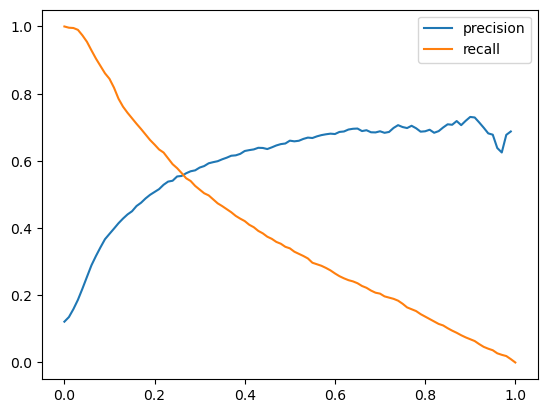

In [18]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

## Question 4
0.22

In [19]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

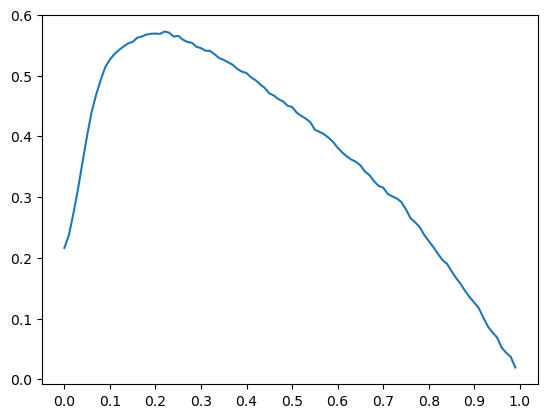

In [20]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

## Qestion 5
0.906 +- 0.005

In [23]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [32]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y
    y_val = df_val.y

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))
    # Calculate Standard Deviation
std_auc = np.std(scores)
std_auc_rounded = round(std_auc, 3)
print(f"Standard Deviation of AUC scores: {std_auc_rounded}")

0.906 +- 0.005
Standard Deviation of AUC scores: 0.005


## Question 6
1

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
     

C=1e-06, 0.701 +- 0.009
C=0.001, 0.861 +- 0.007
C=   1, 0.906 +- 0.005
